# Import Libraries

In [ ]:
import random
import copy
from pathlib import Path
from typing import List, Tuple, Dict
from collections import defaultdict
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import degree, add_self_loops
from torch_geometric.nn import MessagePassing

# Dataset Loading


In [103]:
# Dataset configuration to switch between datasets easily
class DatasetConfig:
    def __init__(self, name, base_path, has_validation=True):
        self.name = name
        self.base_path = Path(base_path)
        self.has_validation = has_validation
        
        self.train_path = self.base_path / "train.txt"
        self.test_path = self.base_path / "test.txt" 
        self.valid_path = self.base_path / "valid.txt" if has_validation else None
    
    def __str__(self):
        return f"Dataset: {self.name} | Path: {self.base_path}"

# Available dataset configurations
DATASETS = {
    'WN18RR': DatasetConfig('WN18RR', '../WN18RR', has_validation=True),
    # Add more datasets here as needed
}

# Select dataset to use
CURRENT_DATASET = 'WN18RR'
config = DATASETS[CURRENT_DATASET]

if config.valid_path:
    print(f"Validation file: {config.valid_path}")

# Check if files exist
for path in [config.train_path, config.test_path, config.valid_path]:
    if path and path.exists():
        print(f"{path}")
    elif path:
        print(f"{path} - File not found!")

Validation file: ..\WN18RR\valid.txt
..\WN18RR\train.txt
..\WN18RR\test.txt
..\WN18RR\valid.txt


In [104]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_dataset(path: Path) -> List[Tuple[str, str, str]]:
    """Load dataset from tab-separated file"""
    data = []
    if not path.exists():
        raise FileNotFoundError(f"Dataset file not found: {path}")
    
    with open(path, "r") as f:
        for line_num, line in enumerate(f, 1):
            try:
                parts = line.strip().split("\t")
                if len(parts) != 3:
                    print(f"Warning: Line {line_num} has {len(parts)} parts, expected 3")
                    continue
                h, r, t = parts
                data.append((h, r, t))
            except Exception as e:
                print(f"Error parsing line {line_num}: {e}")
                continue
    
    print(f"Loaded {len(data)} triples from {path}")
    return data

# Load datasets using the configuration
train_dataset = load_dataset(config.train_path)
test_dataset = load_dataset(config.test_path)
valid_dataset = load_dataset(config.valid_path) if config.valid_path else []

print(f"\nDataset Statistics for {config.name}:")
print(f"Training triples: {len(train_dataset):,}")
print(f"Test triples: {len(test_dataset):,}")
print(f"Validation triples: {len(valid_dataset):,}")

# Build ID maps
entities: set[str] = set()
relations: set[str] = set()
all_data = train_dataset + test_dataset + valid_dataset

for h, r, t in all_data:
    entities.add(h); entities.add(t); relations.add(r)

ent2id: Dict[str, int] = {e: i for i, e in enumerate(sorted(entities))}
rel2id: Dict[str, int] = {r: i for i, r in enumerate(sorted(relations))}
id2ent = {v: k for k, v in ent2id.items()}
id2rel = {v: k for k, v in rel2id.items()}

num_entities = len(ent2id)
num_relations = len(rel2id)
print(f"\nVocabulary Statistics:")
print(f"Entities: {num_entities:,}")
print(f"Relations: {num_relations:,}")

def triples_to_tensor(triples: List[Tuple[str, str, str]]) -> torch.LongTensor:
    """Convert string triples to tensor of IDs"""
    if not triples:
        return torch.empty((0, 3), dtype=torch.long)
    arr = np.array([(ent2id[h], rel2id[r], ent2id[t]) for h, r, t in triples], dtype=np.int64)
    return torch.from_numpy(arr)

# Convert to tensors and move to device
train_triples = triples_to_tensor(train_dataset).to(device)
test_triples = triples_to_tensor(test_dataset).to(device)
valid_triples = triples_to_tensor(valid_dataset).to(device)

print(f"\nTensor shapes:")
print(f"Train: {train_triples.shape}")
print(f"Test: {test_triples.shape}")
print(f"Valid: {valid_triples.shape}")

# Build collapsed undirected graph for LightGCN encoder
print("\nBuilding graph structure...")
edges = []
for h, r, t in train_triples.tolist():
    edges.append((h, t))
    edges.append((t, h))  # Add reverse edges for undirected graph

edge_index = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
edge_index, _ = add_self_loops(edge_index, num_nodes=num_entities)

print(f"Graph edges (with self-loops): {edge_index.shape[1]:,}")
print(f"Graph edge_index shape: {tuple(edge_index.shape)}")

Using device: cpu
Loaded 86835 triples from ..\WN18RR\train.txt
Loaded 3134 triples from ..\WN18RR\test.txt
Loaded 3034 triples from ..\WN18RR\valid.txt

Dataset Statistics for WN18RR:
Training triples: 86,835
Test triples: 3,134
Validation triples: 3,034

Vocabulary Statistics:
Entities: 40,943
Relations: 11

Tensor shapes:
Train: torch.Size([86835, 3])
Test: torch.Size([3134, 3])
Valid: torch.Size([3034, 3])

Building graph structure...
Graph edges (with self-loops): 214,613
Graph edge_index shape: (2, 214613)


# Helper Functions

### Evaluation Metrics
- **AUC**: Area Under the ROC Curve - measures the model's ability to distinguish between positive and negative examples (0.5 = random, 1.0 = perfect)
- **AP**: Average Precision - summarizes precision-recall curve as weighted mean of precisions at each threshold, emphasizing high-precision retrievals
- **Recall**: True positive rate - fraction of actual positive examples that were correctly identified
- **Hits@K**: Percentage of correct entities in top-K predictions (e.g., Hits@10 = % of times correct entity appears in top 10 ranked predictions)
- **MR**: Mean Rank of correct entities - average position of correct entities in ranked lists (lower is better)
- **MRR**: Mean Reciprocal Rank of correct entities - average of 1/rank for correct entities, emphasizes getting correct answers at top positions (higher is better)

In [105]:
@torch.no_grad()
def batch_scores(z: torch.Tensor, pairs: torch.LongTensor, batch_size: int = 4096) -> torch.Tensor:
    """Calculate scores for pairs in batches to avoid memory issues"""
    scores = []
    for i in range(0, pairs.size(1), batch_size):
        batch = pairs[:, i:i+batch_size]
        s = (z[batch[0]] * z[batch[1]]).sum(dim=1)
        scores.append(s)
    return torch.cat(scores, dim=0)

In [106]:
@torch.no_grad()
def evaluate_ranking_metrics(model, edge_index, test_triples, num_entities, 
                            k_values=[1, 3, 5, 10], batch_size=64, 
                            rel_edge_index=None, edge_type=None):

    model.eval()
    
    # Get entity embeddings
    if rel_edge_index is not None and edge_type is not None:
        # R-LightGCN case
        z = model.encode(rel_edge_index, edge_type)
        use_relations = hasattr(model, 'rel_emb')  # Check if model has relation embeddings
    else:
        # LightGCN case
        z = model.encode(edge_index)
        use_relations = False
    
    all_metrics = {
        'head': {'auc': [], 'ap': [], 'recall': [], 'mr': [], 'mrr': [], **{f'hits@{k}': [] for k in k_values}},
        'tail': {'auc': [], 'ap': [], 'recall': [], 'mr': [], 'mrr': [], **{f'hits@{k}': [] for k in k_values}}
    }
    
    # Process in batches to avoid memory issues
    num_batches = (len(test_triples) + batch_size - 1) // batch_size
    
    for mode in ['head', 'tail']:
        print(f"Evaluating {mode} corruption...")
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(test_triples))
            batch_triples = test_triples[start_idx:end_idx]
            
            if len(batch_triples) == 0:
                continue
                
            # For each triple in batch, rank against all entities
            for triple in batch_triples:
                h, r, t = triple.cpu().tolist()
                
                if mode == 'head':
                    target_entity = h
                    if use_relations:
                        # R-LightGCN: Use relation-aware scoring
                        all_heads = torch.arange(num_entities, device=device)
                        all_pairs = torch.stack([all_heads, torch.full_like(all_heads, t)], dim=0)
                        rel_types = torch.full((num_entities,), r, device=device)
                        scores = model.decode(z, all_pairs, rel_types)
                    else:
                        # LightGCN: Simple dot product
                        scores = (z * z[t]).sum(dim=1)
                else:
                    target_entity = t
                    if use_relations:
                        # R-LightGCN: Use relation-aware scoring
                        all_tails = torch.arange(num_entities, device=device)
                        all_pairs = torch.stack([torch.full_like(all_tails, h), all_tails], dim=0)
                        rel_types = torch.full((num_entities,), r, device=device)
                        scores = model.decode(z, all_pairs, rel_types)
                    else:
                        # LightGCN: Simple dot product
                        scores = (z[h] * z).sum(dim=1)
                
                # Get rankings (higher scores = better ranks)
                _, sorted_indices = torch.sort(scores, descending=True)
                rank = (sorted_indices == target_entity).nonzero(as_tuple=True)[0].item() + 1
                
                # Create binary labels for AUC/AP
                y_true = torch.zeros(num_entities, device=device)
                y_true[target_entity] = 1
                y_score = scores
                
                # Convert to CPU for sklearn
                y_true_cpu = y_true.cpu().numpy()
                y_score_cpu = y_score.cpu().numpy()
                
                # Calculate metrics
                try:
                    auc = roc_auc_score(y_true_cpu, y_score_cpu)
                    ap = average_precision_score(y_true_cpu, y_score_cpu)
                except:
                    auc = 0.5  # Random performance
                    ap = 1.0 / num_entities
                
                # Calculate recall
                y_pred_cpu = (y_score_cpu > np.median(y_score_cpu)).astype(int)
                recall = recall_score(y_true_cpu, y_pred_cpu)       

                mr = rank
                mrr = 1.0 / rank
                
                # Hits@K
                hits_at_k = {}
                for k in k_values:
                    hits_at_k[f'hits@{k}'] = 1.0 if rank <= k else 0.0
                
                # Store metrics
                all_metrics[mode]['auc'].append(auc)
                all_metrics[mode]['ap'].append(ap)
                all_metrics[mode]['recall'].append(recall)
                all_metrics[mode]['mr'].append(mr)
                all_metrics[mode]['mrr'].append(mrr)
                for k in k_values:
                    all_metrics[mode][f'hits@{k}'].append(hits_at_k[f'hits@{k}'])
    
    # Average all metrics
    final_metrics = {}
    for mode in ['head', 'tail']:
        final_metrics[mode] = {}
        for metric_name, values in all_metrics[mode].items():
            if values:  # Check if list is not empty
                final_metrics[mode][metric_name] = np.mean(values)
            else:
                final_metrics[mode][metric_name] = 0.0
    
    return final_metrics

In [107]:
def log_and_track_metrics(epoch, avg_loss, val_ranking_metrics, metrics_tracker, model_name="Model"):
    """
    Utility function to track and log training metrics
    
    Args:
        epoch: Current training epoch
        avg_loss: Average loss for the epoch
        val_ranking_metrics: Dictionary containing head/tail metrics from evaluate_ranking_metrics
        metrics_tracker: MetricsTracker instance to store metrics
        model_name: Name of the model for logging (e.g., "LightGCN", "R-LightGCN")
    """
    # Track ALL metrics
    metrics_dict = {
        'epoch': epoch,
        'loss': avg_loss,
        'val_auc_head': val_ranking_metrics['head']['auc'],
        'val_auc_tail': val_ranking_metrics['tail']['auc'],
        'val_ap_head': val_ranking_metrics['head']['ap'],
        'val_ap_tail': val_ranking_metrics['tail']['ap'],
        'val_mrr_head': val_ranking_metrics['head']['mrr'],
        'val_mrr_tail': val_ranking_metrics['tail']['mrr'],
        'val_mr_head': val_ranking_metrics['head']['mr'],
        'val_mr_tail': val_ranking_metrics['tail']['mr'],
        'val_hits@1_head': val_ranking_metrics['head']['hits@1'],
        'val_hits@1_tail': val_ranking_metrics['tail']['hits@1'],
        'val_hits@10_head': val_ranking_metrics['head']['hits@10'], 
        'val_hits@10_tail': val_ranking_metrics['tail']['hits@10'],
    }
    
    metrics_tracker.add(**metrics_dict)
    
    # Print formatted metrics
    print(f"[{model_name}-COMP] Epoch {epoch:03d} | Loss {avg_loss:.4f}")
    print(f"  AUC (H/T): {val_ranking_metrics['head']['auc']:.4f}/{val_ranking_metrics['tail']['auc']:.4f}")
    print(f"  AP (H/T): {val_ranking_metrics['head']['ap']:.4f}/{val_ranking_metrics['tail']['ap']:.4f}")
    print(f"  MRR (H/T): {val_ranking_metrics['head']['mrr']:.4f}/{val_ranking_metrics['tail']['mrr']:.4f}")
    print(f"  Hits@1 (H/T): {val_ranking_metrics['head']['hits@1']:.4f}/{val_ranking_metrics['tail']['hits@1']:.4f}")
    print(f"  Hits@10 (H/T): {val_ranking_metrics['head']['hits@10']:.4f}/{val_ranking_metrics['tail']['hits@10']:.4f}")
    print(f"  MR (H/T): {val_ranking_metrics['head']['mr']:.4f}/{val_ranking_metrics['tail']['mr']:.4f}")

In [108]:
class MetricsTracker:
    def __init__(self):
        self.metrics = defaultdict(list)
    
    def add(self, epoch, **kwargs):
        self.metrics['epoch'].append(epoch)
        for key, value in kwargs.items():
            self.metrics[key].append(value)
    
    def plot(self, title="Training Metrics"):
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        fig.suptitle(title)
        
        # Loss
        axes[0,0].plot(self.metrics['epoch'], self.metrics['loss'])
        axes[0,0].set_title('Training Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        
        # AUC
        if 'val_auc_head' in self.metrics:
            axes[0,1].plot(self.metrics['epoch'], self.metrics['val_auc_head'], label='Head')
            axes[0,1].plot(self.metrics['epoch'], self.metrics['val_auc_tail'], label='Tail')
            axes[0,1].set_title('Validation AUC')
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('AUC')
            axes[0,1].legend()
        
        # AP
        if 'val_ap_head' in self.metrics:
            axes[0,2].plot(self.metrics['epoch'], self.metrics['val_ap_head'], label='Head')
            axes[0,2].plot(self.metrics['epoch'], self.metrics['val_ap_tail'], label='Tail')
            axes[0,2].set_title('Validation AP')
            axes[0,2].set_xlabel('Epoch')
            axes[0,2].set_ylabel('AP')
            axes[0,2].legend()
        
        # MRR
        if 'val_mrr_head' in self.metrics:
            axes[1,0].plot(self.metrics['epoch'], self.metrics['val_mrr_head'], label='Head')
            axes[1,0].plot(self.metrics['epoch'], self.metrics['val_mrr_tail'], label='Tail')
            axes[1,0].set_title('Validation MRR')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('MRR')
            axes[1,0].legend()
        
        # MR (lower is better)
        if 'val_mr_head' in self.metrics:
            axes[2,0].plot(self.metrics['epoch'], self.metrics['val_mr_head'], label='Head')
            axes[2,0].plot(self.metrics['epoch'], self.metrics['val_mr_tail'], label='Tail')
            axes[2,0].set_title('Validation MR (lower=better)')
            axes[2,0].set_xlabel('Epoch')
            axes[2,0].set_ylabel('MR')
            axes[2,0].legend()

        # Hits@1
        if 'val_hits@1_head' in self.metrics:
            axes[1,1].plot(self.metrics['epoch'], self.metrics['val_hits@1_head'], label='Head')
            axes[1,1].plot(self.metrics['epoch'], self.metrics['val_hits@1_tail'], label='Tail')
            axes[1,1].set_title('Validation Hits@1')
            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('Hits@1')
            axes[1,1].legend()
        
        # Hits@10
        if 'val_hits@10_head' in self.metrics:
            axes[1,2].plot(self.metrics['epoch'], self.metrics['val_hits@10_head'], label='Head')
            axes[1,2].plot(self.metrics['epoch'], self.metrics['val_hits@10_tail'], label='Tail')
            axes[1,2].set_title('Validation Hits@10')
            axes[1,2].set_xlabel('Epoch')
            axes[1,2].set_ylabel('Hits@10')
            axes[1,2].legend()
        
        # Remove unused subplots
        axes[2,1].remove()
        axes[2,2].remove()
        
        plt.tight_layout()
        plt.show()

### Negative Sampling
- A training technique used in knowledge graph link prediction to create "negative examples", triples that are likely to be false. 
- Since knowledge graphs only contain positive facts (true triples), we need to artificially create negative examples for the model to learn what relationships are incorrect.
- Both head and tail corruptions are used to train the model to understand connections flowing in both directions. Model learns "What subjects fit this relation-object" and "What object fits this subject-relation".

In [110]:
@torch.no_grad()
def pairs_from_triples(triples: torch.LongTensor) -> torch.LongTensor:
    """
    Convert (h, r, t) -> pairs [2, N] = (h, t) for decoding on collapsed graph.
    """
    return triples[:, [0, 2]].t().contiguous()  # [2, N]

@torch.no_grad()
def negative_sample_heads(triples: torch.LongTensor, num_nodes: int) -> torch.LongTensor:
    """
    Corrupt heads: (h, r, t) -> (h', t)
    Returns pairs [2, N].
    """
    N = triples.size(0)
    neg_h = torch.randint(0, num_nodes, (N,), device=triples.device)
    t = triples[:, 2]
    return torch.stack([neg_h, t], dim=0)

@torch.no_grad()
def negative_sample_tails(triples: torch.LongTensor, num_nodes: int) -> torch.LongTensor:
    """
    Corrupt tails: (h, r, t) -> (h, t')
    Returns pairs [2, N].
    """
    N = triples.size(0)
    h = triples[:, 0]
    neg_t = torch.randint(0, num_nodes, (N,), device=triples.device)
    return torch.stack([h, neg_t], dim=0)


### Early Stopping

In [113]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001, restore_best_weights=True, metric='avg_auc'):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.metric = metric
        self.best_score = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, current_metrics, model):
        # Calculate score based on chosen metric
        if self.metric == 'avg_auc':
            score = (current_metrics['head']['auc'] + current_metrics['tail']['auc']) / 2
        elif self.metric == 'avg_mrr':
            score = (current_metrics['head']['mrr'] + current_metrics['tail']['mrr']) / 2
        elif self.metric == 'avg_hits@1':
            score = (current_metrics['head']['hits@1'] + current_metrics['tail']['hits@1']) / 2
        else:
            score = (current_metrics['head']['auc'] + current_metrics['tail']['auc']) / 2
            
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = score
            self.counter = 0
            self.save_checkpoint(model)
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = copy.deepcopy(model.state_dict())

# Model 1 LightGCN
- We also add new inverse type of relation on top of the 11 that already exists.
- This allows for information to be passed around which originally did not.
- A -> B is one way, and there should be an inverse relationship (or some information) which is missed out.

In [ ]:
# -------- LightGCN layer --------
class LightGCNConv(MessagePassing):
    def __init__(self):
        super().__init__(aggr='add')

    # Compute symmetric normalization term D^-0.5*A*D^-0.5 to propagate messages through normalized adjacency
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.clamp(min=1).pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, norm=norm)

    # Scales the neighbor embeddings
    def message(self, x_j: torch.Tensor, norm: torch.Tensor) -> torch.Tensor:
        return norm.view(-1, 1) * x_j

# -------- LightGCN encoder + dot-product decoder --------
class LightGCN(nn.Module):
    # Initialize trainable node embeddings
    def __init__(self, num_nodes: int, emb_dim: int = 64, num_layers: int = 3):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(num_layers)])
        self.num_layers = num_layers

    def encode(self, edge_index: torch.Tensor) -> torch.Tensor:
        x0 = self.embedding.weight
        out = x0
        x = x0
        # Each layer's output is accumulated and averaged
        for conv in self.convs:
            x = conv(x, edge_index)
            out = out + x
        return out / (self.num_layers + 1)

    # Compute dot product between node embeddings for each edge (positive or negative pair)
    @staticmethod
    def decode(z: torch.Tensor, pairs: torch.LongTensor) -> torch.Tensor:
        # pairs: [2, B] with [src; dst]
        return (z[pairs[0]] * z[pairs[1]]).sum(dim=1)

In [111]:
def train_one_epoch_lightgcn(model, triples, optimizer, edge_index, 
                            num_entities, batch_size, shuffle=True):
    """
    Train LightGCN with batching
    """
    model.train()
    
    total_loss = 0.0
    num_batches = 0
    
    # Create batches from training triples
    N = triples.size(0)
    if shuffle:
        indices = torch.randperm(N, device=triples.device)
    else:
        indices = torch.arange(N, device=triples.device)

    for i in range(0, N, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_triples = triples[batch_indices]
        
        z = model.encode(edge_index)
        
        # Generate positive and negative pairs for this batch
        pos_pairs = pairs_from_triples(batch_triples)
        neg_pairs = negative_sample_heads(batch_triples, num_entities)
        
        # Simple dot-product decoding (no relation types)
        pos_scores = model.decode(z, pos_pairs)
        neg_scores = model.decode(z, neg_pairs)
        
        # Compute loss for this batch
        batch_scores = torch.cat([pos_scores, neg_scores])
        batch_labels = torch.cat([
            torch.ones_like(pos_scores),
            torch.zeros_like(neg_scores)
        ])
        
        loss = F.binary_cross_entropy_with_logits(batch_scores, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

Starting LightGCN training ...
Max epochs: 100, Early stopping patience: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating head corruption...
Evaluating tail corruption...


  1%|          | 1/100 [00:07<12:04,  7.32s/it]

[LightGCN-COMP] Epoch 001 | Loss 0.6914
  AUC (H/T): 0.9202/0.9271
  AP (H/T): 0.0480/0.0475
  MRR (H/T): 0.0480/0.0475
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.1200/0.0800
  MR (H/T): 3269.8400/2985.5200


  4%|▍         | 4/100 [00:30<12:55,  8.08s/it]

Evaluating head corruption...
Evaluating tail corruption...


  5%|▌         | 5/100 [00:44<16:17, 10.29s/it]

[LightGCN-COMP] Epoch 005 | Loss 0.5775
  AUC (H/T): 0.9250/0.9387
  AP (H/T): 0.0510/0.0545
  MRR (H/T): 0.0510/0.0545
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.1800/0.1200
  MR (H/T): 3073.0800/2509.1400


  9%|▉         | 9/100 [01:07<09:34,  6.31s/it]

Evaluating head corruption...
Evaluating tail corruption...


 10%|█         | 10/100 [01:14<09:53,  6.59s/it]

[LightGCN-COMP] Epoch 010 | Loss 0.4721
  AUC (H/T): 0.9276/0.9446
  AP (H/T): 0.0595/0.0668
  MRR (H/T): 0.0595/0.0668
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.1800/0.1600
  MR (H/T): 2963.8600/2268.6000


 14%|█▍        | 14/100 [01:33<07:21,  5.13s/it]

Evaluating head corruption...
Evaluating tail corruption...


 15%|█▌        | 15/100 [01:40<08:06,  5.72s/it]

[LightGCN-COMP] Epoch 015 | Loss 0.4326
  AUC (H/T): 0.9293/0.9425
  AP (H/T): 0.0724/0.0743
  MRR (H/T): 0.0724/0.0743
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.2200/0.2400
  MR (H/T): 2896.8200/2355.4200


 19%|█▉        | 19/100 [01:59<06:41,  4.96s/it]

Evaluating head corruption...
Evaluating tail corruption...


 20%|██        | 20/100 [02:05<07:13,  5.42s/it]

[LightGCN-COMP] Epoch 020 | Loss 0.4137
  AUC (H/T): 0.9289/0.9372
  AP (H/T): 0.0753/0.0809
  MRR (H/T): 0.0753/0.0809
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.2400/0.3000
  MR (H/T): 2913.0400/2573.0000


 24%|██▍       | 24/100 [02:25<06:22,  5.03s/it]

Evaluating head corruption...
Evaluating tail corruption...


 25%|██▌       | 25/100 [02:32<07:04,  5.66s/it]

[LightGCN-COMP] Epoch 025 | Loss 0.4045
  AUC (H/T): 0.9306/0.9357
  AP (H/T): 0.0749/0.0815
  MRR (H/T): 0.0749/0.0815
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.2400/0.2800
  MR (H/T): 2843.6800/2635.4600


 29%|██▉       | 29/100 [02:51<05:48,  4.90s/it]

Evaluating head corruption...
Evaluating tail corruption...


 30%|███       | 30/100 [02:58<06:25,  5.51s/it]

[LightGCN-COMP] Epoch 030 | Loss 0.3990
  AUC (H/T): 0.9272/0.9373
  AP (H/T): 0.0795/0.0854
  MRR (H/T): 0.0795/0.0854
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.2400/0.3000
  MR (H/T): 2980.0800/2568.8200


 34%|███▍      | 34/100 [03:17<05:23,  4.90s/it]

Evaluating head corruption...
Evaluating tail corruption...


 35%|███▌      | 35/100 [03:24<05:57,  5.51s/it]

[LightGCN-COMP] Epoch 035 | Loss 0.3955
  AUC (H/T): 0.9273/0.9356
  AP (H/T): 0.0826/0.0884
  MRR (H/T): 0.0826/0.0884
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.2400/0.3200
  MR (H/T): 2977.0800/2638.8800


 39%|███▉      | 39/100 [03:43<04:56,  4.86s/it]

Evaluating head corruption...
Evaluating tail corruption...


 40%|████      | 40/100 [03:50<05:26,  5.45s/it]

[LightGCN-COMP] Epoch 040 | Loss 0.3937
  AUC (H/T): 0.9259/0.9336
  AP (H/T): 0.0837/0.0896
  MRR (H/T): 0.0837/0.0896
  Hits@1 (H/T): 0.0000/0.0200
  Hits@10 (H/T): 0.2400/0.3000
  MR (H/T): 3033.6800/2719.6200


 44%|████▍     | 44/100 [04:09<04:35,  4.92s/it]

Evaluating head corruption...
Evaluating tail corruption...


 45%|████▌     | 45/100 [04:16<05:01,  5.48s/it]

[LightGCN-COMP] Epoch 045 | Loss 0.3917
  AUC (H/T): 0.9260/0.9330
  AP (H/T): 0.0931/0.0932
  MRR (H/T): 0.0931/0.0932
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.2400/0.3200
  MR (H/T): 3030.6800/2743.4200


 49%|████▉     | 49/100 [04:34<04:02,  4.75s/it]

Evaluating head corruption...
Evaluating tail corruption...


 50%|█████     | 50/100 [04:41<04:31,  5.43s/it]

[LightGCN-COMP] Epoch 050 | Loss 0.3902
  AUC (H/T): 0.9248/0.9316
  AP (H/T): 0.1042/0.0959
  MRR (H/T): 0.1042/0.0959
  Hits@1 (H/T): 0.0400/0.0200
  Hits@10 (H/T): 0.2600/0.3200
  MR (H/T): 3080.1200/2801.5000


 54%|█████▍    | 54/100 [05:01<03:49,  4.99s/it]

Evaluating head corruption...
Evaluating tail corruption...


 55%|█████▌    | 55/100 [05:08<04:13,  5.63s/it]

[LightGCN-COMP] Epoch 055 | Loss 0.3891
  AUC (H/T): 0.9243/0.9312
  AP (H/T): 0.0969/0.0999
  MRR (H/T): 0.0969/0.0999
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.2600/0.3200
  MR (H/T): 3101.8000/2819.1800


 59%|█████▉    | 59/100 [05:26<03:16,  4.80s/it]

Evaluating head corruption...
Evaluating tail corruption...


 59%|█████▉    | 59/100 [05:33<03:52,  5.66s/it]

[LightGCN-COMP] Epoch 060 | Loss 0.3862
  AUC (H/T): 0.9249/0.9332
  AP (H/T): 0.0948/0.1038
  MRR (H/T): 0.0948/0.1038
  Hits@1 (H/T): 0.0200/0.0200
  Hits@10 (H/T): 0.2600/0.3200
  MR (H/T): 3077.0400/2735.7800
Early stopping triggered at epoch 60
Best AUC: 0.9361

LightGCN training completed!


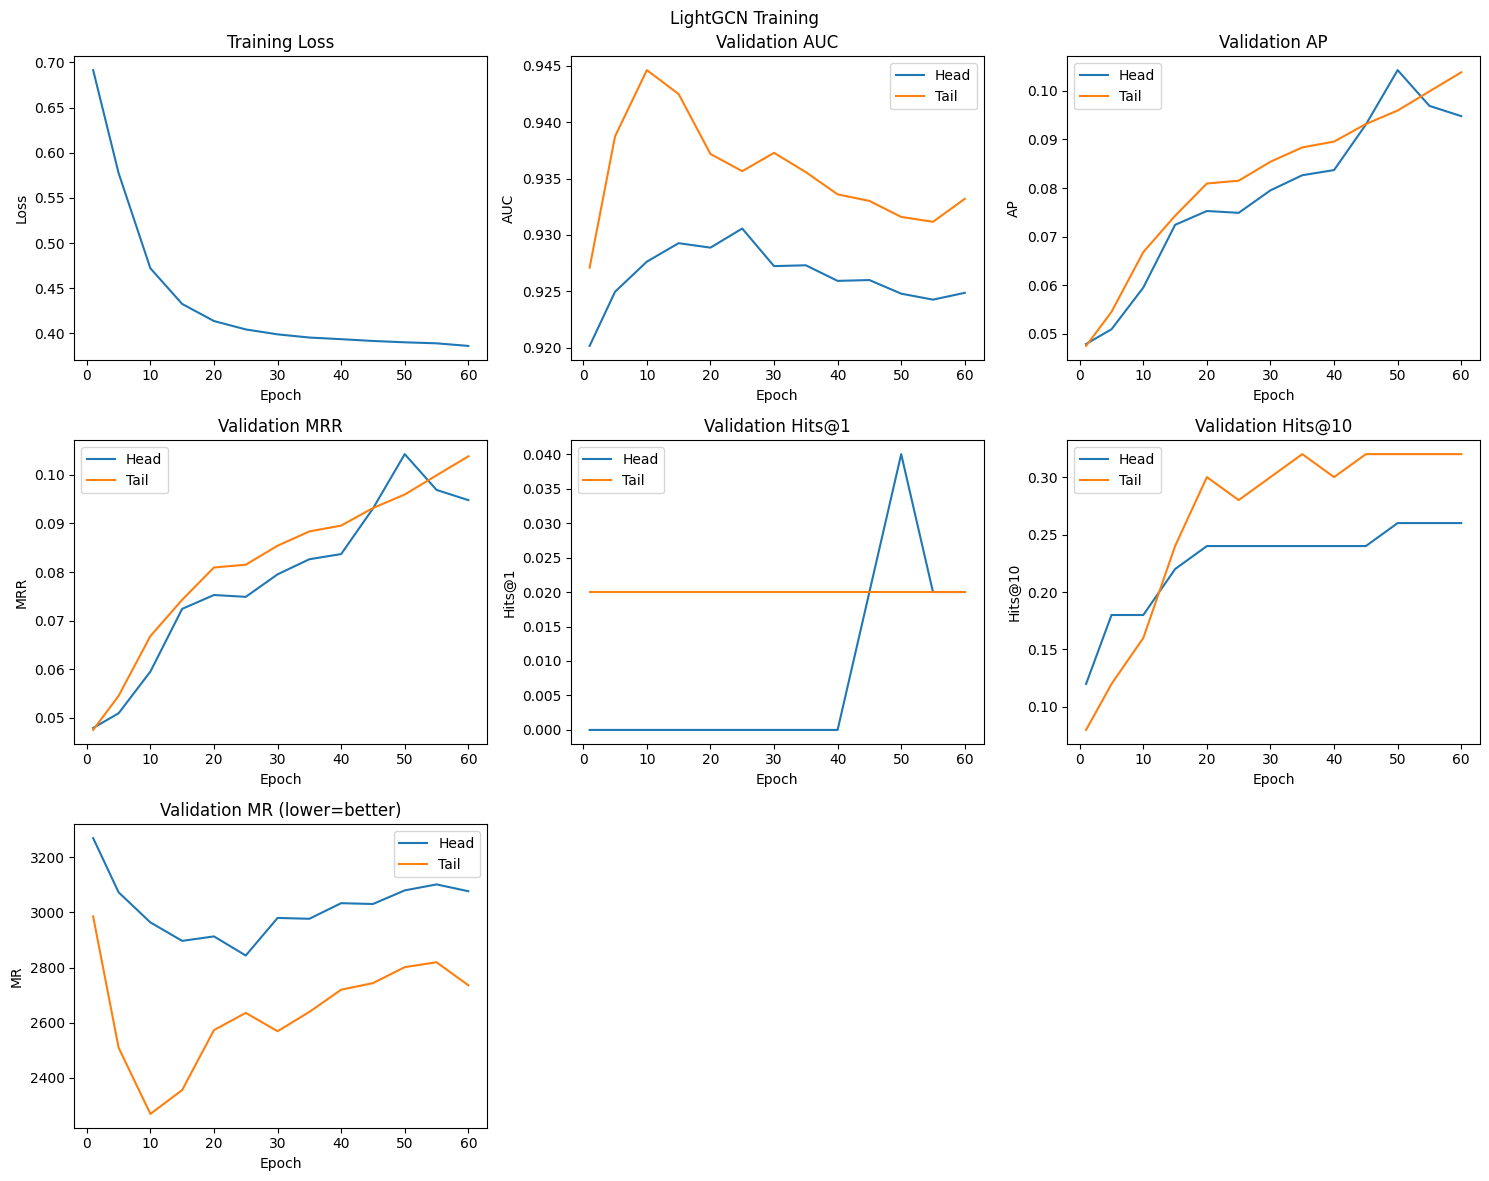

Evaluating head corruption...
Evaluating tail corruption...

[LightGCN with Shuffled Triples][TEST RESULTS]
AUC (H/T): 0.9099/0.9164
MRR (H/T): 0.0563/0.0980
Hits@1 (H/T): 0.0300/0.0300
Hits@10 (H/T): 0.1000/0.2200
MR (H/T): 3691.5/3422.7


In [115]:
lr = 1e-3
epochs = 100
emb_dim = 64
num_layers = 3
eval_every = 5
batch_size = 2048
patience = 10

# Initialize tracking with comprehensive metrics
lightgcn_metrics_tracker = MetricsTracker()
lightgcn_early_stopping = EarlyStopping(patience=patience, min_delta=0.001, metric='avg_auc')

# Create new model for comprehensive training
lightgcn_3 = LightGCN(num_nodes=num_entities, emb_dim=emb_dim, num_layers=num_layers).to(device)
opt_comprehensive = torch.optim.Adam(lightgcn_3.parameters(), lr=lr)

print("Starting LightGCN training ...")
print(f"Max epochs: {epochs}, Early stopping patience: {patience}")

for epoch in tqdm(range(1, epochs + 1)):
    avg_loss = train_one_epoch_lightgcn(
        lightgcn_3, train_triples, opt_comprehensive, 
        edge_index, num_entities, 
        batch_size, True
    )

    # Comprehensive evaluation every epoch (using small subset for speed)
    if epoch % eval_every == 0 or epoch == 1:
        lightgcn_3.eval()
        
        # Use small subset for comprehensive metrics to avoid long computation
        val_subset = valid_triples[:50] if len(valid_triples) > 50 else valid_triples
        
        # Get comprehensive ranking metrics
        lightgcn_ranking_metrics = evaluate_ranking_metrics(
            lightgcn_3, edge_index, val_subset, num_entities, 
            k_values=[1, 3, 5, 10], batch_size=10
        )
        
        log_and_track_metrics(
            epoch=epoch,
            avg_loss=avg_loss,
            val_ranking_metrics=lightgcn_ranking_metrics,
            metrics_tracker=lightgcn_metrics_tracker,
            model_name="LightGCN"
        )

        if lightgcn_early_stopping(lightgcn_ranking_metrics, lightgcn_3):
            print(f"Early stopping triggered at epoch {epoch}")
            print(f"Best AUC: {lightgcn_early_stopping.best_score:.4f}")
            break

print("\nLightGCN training completed!")

# Plot all metrics
lightgcn_metrics_tracker.plot("LightGCN Training")

# Final comprehensive test evaluation
lightgcn_3.eval()
test_subset = test_triples[:100]
lightgcn_final_test_metrics = evaluate_ranking_metrics(
    lightgcn_3, edge_index, test_subset, num_entities, 
    k_values=[1, 3, 5, 10], batch_size=20
)

print(f"\n[LightGCN with Shuffled Triples][TEST RESULTS]")
print(f"AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
print(f"MRR (H/T): {lightgcn_final_test_metrics['head']['mrr']:.4f}/{lightgcn_final_test_metrics['tail']['mrr']:.4f}")
print(f"Hits@1 (H/T): {lightgcn_final_test_metrics['head']['hits@1']:.4f}/{lightgcn_final_test_metrics['tail']['hits@1']:.4f}")
print(f"Hits@10 (H/T): {lightgcn_final_test_metrics['head']['hits@10']:.4f}/{lightgcn_final_test_metrics['tail']['hits@10']:.4f}")
print(f"MR (H/T): {lightgcn_final_test_metrics['head']['mr']:.1f}/{lightgcn_final_test_metrics['tail']['mr']:.1f}")

# Model 2 R-LightGCN

## Old code

In [116]:
# -------- R-LightGCN --------
class RLightGCNConv(MessagePassing):
    def __init__(self, num_relations: int):
        super().__init__(aggr='add')
        # Each relation has its own learnable scalar weight (starts at 1)
        self.alpha = nn.Parameter(torch.ones(num_relations))

    # Degree normalization
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_type: torch.LongTensor) -> torch.Tensor:
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.clamp(min=1).pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, edge_type=edge_type, norm=norm)

    def message(self, x_j: torch.Tensor, edge_type: torch.LongTensor, norm: torch.Tensor) -> torch.Tensor:
        w = self.alpha[edge_type].view(-1, 1)    # weight message by relation type
        return w * norm.view(-1, 1) * x_j

class RLightGCN(nn.Module):
    def __init__(self, num_nodes: int, num_relations: int, emb_dim: int = 64, num_layers: int = 3):
        super().__init__()
        self.embedding = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.convs = nn.ModuleList([RLightGCNConv(num_relations) for _ in range(num_layers)])
        self.num_layers = num_layers

    def encode(self, edge_index: torch.Tensor, edge_type: torch.LongTensor) -> torch.Tensor:
        x0 = self.embedding.weight
        out = x0
        x = x0
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            out = out + x
        return out / (self.num_layers + 1)

    @staticmethod
    def decode(z: torch.Tensor, pairs: torch.LongTensor) -> torch.Tensor:
        return (z[pairs[0]] * z[pairs[1]]).sum(dim=1)

## New code

In [117]:
# -------- R-LightGCN Layer --------
class RLightGCNConv(MessagePassing):
    def __init__(self, num_relations: int, emb_dim: int, rel_emb: nn.Embedding):
        super().__init__(aggr='add')
        self.rel_emb = rel_emb   # share the same relation embedding from the main model
        self.emb_dim = emb_dim

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor, edge_type: torch.LongTensor) -> torch.Tensor:
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.clamp(min=1).pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        return self.propagate(edge_index, x=x, edge_type=edge_type, norm=norm)

    def message(self, x_j: torch.Tensor, edge_type: torch.LongTensor, norm: torch.Tensor) -> torch.Tensor:
        # Each relation type has its own embedding vector
        rel_vec = self.rel_emb(edge_type)           # [num_edges, emb_dim]
        return norm.view(-1, 1) * (x_j * rel_vec)   # elementwise scaling by relation embedding


# -------- R-LightGCN Model --------
class RLightGCN(nn.Module):
    def __init__(self, num_nodes: int, num_relations: int, emb_dim: int = 64, num_layers: int = 3):
        super().__init__()

        # Node embeddings
        self.embedding = nn.Embedding(num_nodes, emb_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        
        # Relation embeddings (shared across layers)
        self.rel_emb = nn.Embedding(num_relations, emb_dim)
        nn.init.xavier_uniform_(self.rel_emb.weight)

        # Pass relation embedding into each conv layer
        self.convs = nn.ModuleList([
            RLightGCNConv(num_relations, emb_dim, self.rel_emb)
            for _ in range(num_layers)
        ])
        self.num_layers = num_layers

    def encode(self, edge_index: torch.Tensor, edge_type: torch.LongTensor) -> torch.Tensor:
        x0 = self.embedding.weight
        out = x0
        x = x0
        for conv in self.convs:
            x = conv(x, edge_index, edge_type)
            out = out + x
        return out / (self.num_layers + 1)

    def decode(self, z: torch.Tensor, pairs: torch.LongTensor, rel_type: torch.LongTensor) -> torch.Tensor:
        head, tail = pairs
        r_emb = self.rel_emb(rel_type)
        return (z[head] * r_emb * z[tail]).sum(dim=1)

    def forward(self, edge_index, edge_type, pairs, rel_type):
        z = self.encode(edge_index, edge_type)
        return self.decode(z, pairs, rel_type)


In [118]:
def train_one_epoch_r_lightgcn(model, triples, optimizer, rel_edge_index, edge_type, 
                               num_entities, batch_size=2048, shuffle=True):
    """
    Train R-LightGCN with batching
    """
    model.train()
    
    total_loss = 0.0
    num_batches = 0
    
    # Create batches from shuffled triples
    N = triples.size(0)

    if shuffle:
        indices = torch.randperm(N, device=triples.device)
    else:
        indices = torch.arange(N, device=triples.device)
    
    for i in range(0, N, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_triples = triples[batch_indices]
        
        z = model.encode(rel_edge_index, edge_type)

        # Generate positive and negative pairs for this batch
        pos_pairs = pairs_from_triples(batch_triples)
        neg_pairs = negative_sample_heads(batch_triples, num_entities)
        
        # Get relation types for positive and negative pairs
        pos_rel_type = batch_triples[:, 1]
        neg_rel_type = pos_rel_type.clone()  # Same relations for negatives
        
        # Decode scores
        pos_scores = model.decode(z, pos_pairs, pos_rel_type)
        neg_scores = model.decode(z, neg_pairs, neg_rel_type)
        
        # Compute loss for this batch
        batch_scores = torch.cat([pos_scores, neg_scores])
        batch_labels = torch.cat([
            torch.ones_like(pos_scores),
            torch.zeros_like(neg_scores)
        ])
        
        loss = F.binary_cross_entropy_with_logits(batch_scores, batch_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

Starting R-LightGCN training with enhanced features...
Max epochs: 100, Early stopping patience: 10


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating head corruption...
Evaluating tail corruption...


  1%|          | 1/100 [00:12<19:53, 12.06s/it]

[R-LightGCN-COMP] Epoch 001 | Loss 0.6931
  AUC (H/T): 0.6202/0.6231
  AP (H/T): 0.0028/0.0129
  MRR (H/T): 0.0028/0.0129
  Hits@1 (H/T): 0.0000/0.0000
  Hits@10 (H/T): 0.0000/0.0400
  MR (H/T): 15549.3800/15433.0800


  4%|▍         | 4/100 [00:39<15:07,  9.45s/it]

Evaluating head corruption...
Evaluating tail corruption...


  5%|▌         | 5/100 [00:50<16:04, 10.15s/it]

[R-LightGCN-COMP] Epoch 005 | Loss 0.6909
  AUC (H/T): 0.8289/0.8426
  AP (H/T): 0.0736/0.0777
  MRR (H/T): 0.0736/0.0777
  Hits@1 (H/T): 0.0400/0.0400
  Hits@10 (H/T): 0.1400/0.1200
  MR (H/T): 7007.6200/6443.4400


  9%|▉         | 9/100 [01:26<14:06,  9.31s/it]

Evaluating head corruption...
Evaluating tail corruption...


 10%|█         | 10/100 [01:38<15:05, 10.06s/it]

[R-LightGCN-COMP] Epoch 010 | Loss 0.4849
  AUC (H/T): 0.8531/0.8519
  AP (H/T): 0.1088/0.1069
  MRR (H/T): 0.1088/0.1069
  Hits@1 (H/T): 0.0400/0.0600
  Hits@10 (H/T): 0.2400/0.2000
  MR (H/T): 6015.1800/6066.2600


 14%|█▍        | 14/100 [02:14<13:10,  9.19s/it]

Evaluating head corruption...
Evaluating tail corruption...


 15%|█▌        | 15/100 [02:26<14:11, 10.02s/it]

[R-LightGCN-COMP] Epoch 015 | Loss 0.4035
  AUC (H/T): 0.8441/0.8480
  AP (H/T): 0.1467/0.1454
  MRR (H/T): 0.1467/0.1454
  Hits@1 (H/T): 0.0600/0.0800
  Hits@10 (H/T): 0.2800/0.2600
  MR (H/T): 6384.1200/6225.5600


 19%|█▉        | 19/100 [03:02<12:31,  9.28s/it]

Evaluating head corruption...
Evaluating tail corruption...


 20%|██        | 20/100 [03:14<13:21, 10.02s/it]

[R-LightGCN-COMP] Epoch 020 | Loss 0.3952
  AUC (H/T): 0.8342/0.8298
  AP (H/T): 0.1696/0.1561
  MRR (H/T): 0.1696/0.1561
  Hits@1 (H/T): 0.0800/0.0800
  Hits@10 (H/T): 0.3000/0.2800
  MR (H/T): 6791.0400/6969.7200


 24%|██▍       | 24/100 [03:49<11:33,  9.12s/it]

Evaluating head corruption...
Evaluating tail corruption...


 25%|██▌       | 25/100 [04:01<12:28,  9.99s/it]

[R-LightGCN-COMP] Epoch 025 | Loss 0.3910
  AUC (H/T): 0.8254/0.8183
  AP (H/T): 0.1589/0.1590
  MRR (H/T): 0.1589/0.1590
  Hits@1 (H/T): 0.0600/0.0800
  Hits@10 (H/T): 0.3200/0.3400
  MR (H/T): 7148.8800/7440.3000


 29%|██▉       | 29/100 [04:36<10:44,  9.08s/it]

Evaluating head corruption...
Evaluating tail corruption...


 30%|███       | 30/100 [04:48<11:35,  9.94s/it]

[R-LightGCN-COMP] Epoch 030 | Loss 0.3875
  AUC (H/T): 0.8230/0.8156
  AP (H/T): 0.1520/0.1666
  MRR (H/T): 0.1520/0.1666
  Hits@1 (H/T): 0.0400/0.0800
  Hits@10 (H/T): 0.3800/0.3400
  MR (H/T): 7249.2200/7549.5400


 34%|███▍      | 34/100 [05:24<10:02,  9.12s/it]

Evaluating head corruption...
Evaluating tail corruption...


 35%|███▌      | 35/100 [05:35<10:44,  9.92s/it]

[R-LightGCN-COMP] Epoch 035 | Loss 0.3857
  AUC (H/T): 0.8230/0.8153
  AP (H/T): 0.1647/0.1670
  MRR (H/T): 0.1647/0.1670
  Hits@1 (H/T): 0.0600/0.0800
  Hits@10 (H/T): 0.3800/0.3800
  MR (H/T): 7249.4800/7564.0600


 39%|███▉      | 39/100 [06:11<09:18,  9.16s/it]

Evaluating head corruption...
Evaluating tail corruption...


 40%|████      | 40/100 [06:23<09:56,  9.94s/it]

[R-LightGCN-COMP] Epoch 040 | Loss 0.3853
  AUC (H/T): 0.8207/0.8133
  AP (H/T): 0.1773/0.1830
  MRR (H/T): 0.1773/0.1830
  Hits@1 (H/T): 0.0600/0.0800
  Hits@10 (H/T): 0.3800/0.3800
  MR (H/T): 7342.2000/7643.1000


 44%|████▍     | 44/100 [06:58<08:29,  9.09s/it]

Evaluating head corruption...
Evaluating tail corruption...


 45%|████▌     | 45/100 [07:10<09:02,  9.86s/it]

[R-LightGCN-COMP] Epoch 045 | Loss 0.3848
  AUC (H/T): 0.8207/0.8144
  AP (H/T): 0.1933/0.1755
  MRR (H/T): 0.1933/0.1755
  Hits@1 (H/T): 0.0800/0.0600
  Hits@10 (H/T): 0.4200/0.4000
  MR (H/T): 7341.0400/7599.9800


 49%|████▉     | 49/100 [07:46<07:53,  9.28s/it]

Evaluating head corruption...
Evaluating tail corruption...


 50%|█████     | 50/100 [07:58<08:18,  9.98s/it]

[R-LightGCN-COMP] Epoch 050 | Loss 0.3818
  AUC (H/T): 0.8231/0.8171
  AP (H/T): 0.1974/0.1918
  MRR (H/T): 0.1974/0.1918
  Hits@1 (H/T): 0.0800/0.1000
  Hits@10 (H/T): 0.4200/0.4000
  MR (H/T): 7244.8400/7488.4400


 54%|█████▍    | 54/100 [08:33<06:58,  9.10s/it]

Evaluating head corruption...
Evaluating tail corruption...


 55%|█████▌    | 55/100 [08:45<07:28,  9.97s/it]

[R-LightGCN-COMP] Epoch 055 | Loss 0.3832
  AUC (H/T): 0.8239/0.8192
  AP (H/T): 0.1848/0.2010
  MRR (H/T): 0.1848/0.2010
  Hits@1 (H/T): 0.0600/0.1000
  Hits@10 (H/T): 0.4200/0.4000
  MR (H/T): 7212.2600/7404.8800


 59%|█████▉    | 59/100 [09:21<06:13,  9.12s/it]

Evaluating head corruption...
Evaluating tail corruption...


 59%|█████▉    | 59/100 [09:33<06:38,  9.72s/it]

[R-LightGCN-COMP] Epoch 060 | Loss 0.3827
  AUC (H/T): 0.8241/0.8200
  AP (H/T): 0.1819/0.2023
  MRR (H/T): 0.1819/0.2023
  Hits@1 (H/T): 0.0600/0.1000
  Hits@10 (H/T): 0.4200/0.4000
  MR (H/T): 7204.2800/7370.4200
Early stopping triggered at epoch 60
Best AUC: 0.8525
R-LightGCN training completed!


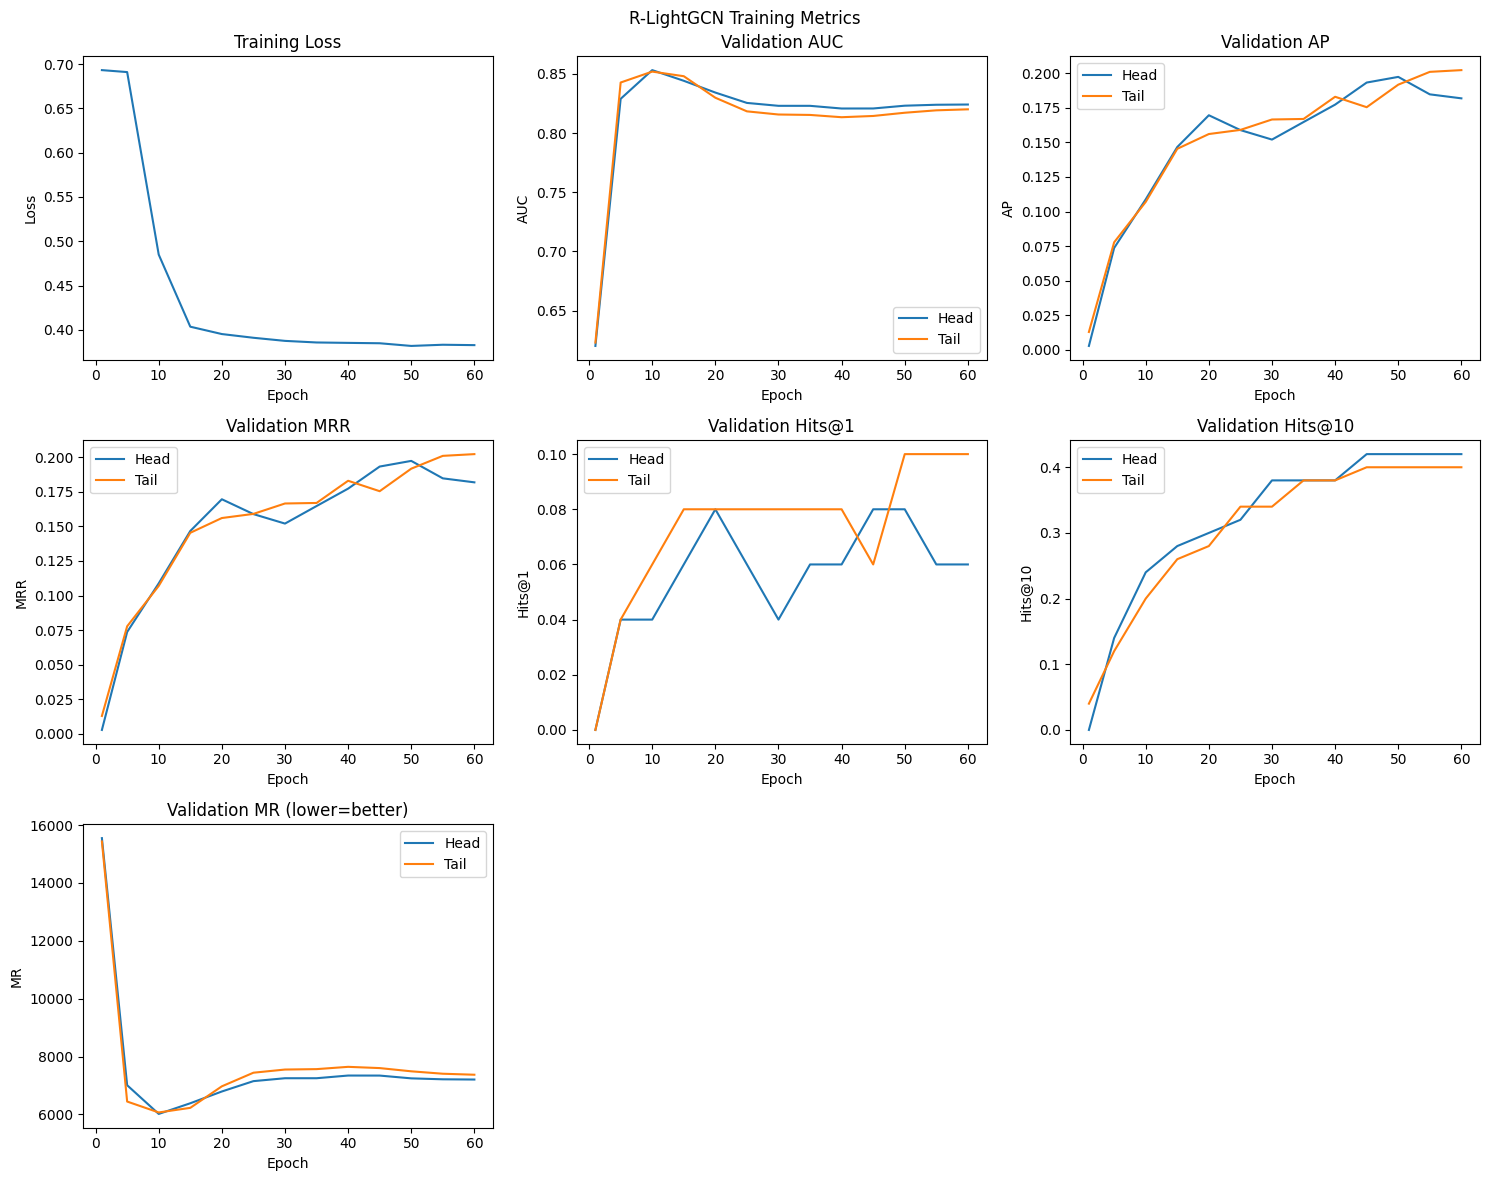

Evaluating head corruption...
Evaluating tail corruption...

[R-LightGCN with Shuffled Triples][TEST RESULTS]
AUC (H/T): 0.8045/0.8096
MRR (H/T): 0.0616/0.0957
Hits@1 (H/T): 0.0100/0.0400
Hits@10 (H/T): 0.1800/0.2200
MR (H/T): 8005.3/7797.5


In [121]:
# Build relation-aware edge_index and edge_type (with reverse edges)
rel_edges = []
rel_types = []

for h, r, t in train_triples.tolist():
    rel_edges.append((h, t)); rel_types.append(r)
    rel_edges.append((t, h)); rel_types.append(r)  # add reverse edge with same relation

rel_edge_index = torch.tensor(rel_edges, dtype=torch.long, device=device).t().contiguous()
edge_type = torch.tensor(rel_types, dtype=torch.long, device=device)

# Add self-loops with a new relation id
self_loop_edges = torch.arange(num_entities, device=device)
self_loop_edges = torch.stack([self_loop_edges, self_loop_edges], dim=0)  # [2, N]
rel_edge_index = torch.cat([rel_edge_index, self_loop_edges], dim=1)

self_loop_types = torch.full((num_entities,), num_relations, dtype=torch.long, device=device)
edge_type = torch.cat([edge_type, self_loop_types], dim=0)

# update relation count
num_relations_with_loops = num_relations + 1

# Training parameters
lr = 1e-3
epochs = 100
emb_dim = 64
num_layers = 3
eval_every = 5
patience = 10
batch_size = 2048

# Initialize tracking for R-LightGCN
r_metrics_tracker = MetricsTracker()
r_early_stopping = EarlyStopping(patience=patience, min_delta=0.001, metric='avg_auc')

r_lightgcn_3 = RLightGCN(
    num_nodes=num_entities,
    num_relations=num_relations_with_loops,
    emb_dim=emb_dim,
    num_layers=num_layers
).to(device)

ropt = torch.optim.Adam(r_lightgcn_3.parameters(), lr=lr)

print("Starting R-LightGCN training with enhanced features...")
print(f"Max epochs: {epochs}, Early stopping patience: {patience}")

for epoch in tqdm(range(1, epochs + 1)):    
    # Train with batching
    avg_loss = train_one_epoch_r_lightgcn(
        r_lightgcn_3, train_triples, ropt, 
        rel_edge_index, edge_type, num_entities, 
        batch_size, True
    )

    # Evaluation and metrics tracking
    if epoch % eval_every == 0 or epoch == 1:
        r_lightgcn_3.eval()

            # Use small subset for comprehensive metrics to avoid long computation
        val_subset = valid_triples[:50] if len(valid_triples) > 50 else valid_triples
        
        # Get comprehensive ranking metrics
        r_ranking_metrics = evaluate_ranking_metrics(
            r_lightgcn_3, None, val_subset, num_entities, 
            k_values=[1, 3, 5, 10], batch_size=10,
            rel_edge_index=rel_edge_index, edge_type=edge_type
        )

        log_and_track_metrics(
            epoch=epoch,
            avg_loss=avg_loss,
            val_ranking_metrics=r_ranking_metrics,
            metrics_tracker=r_metrics_tracker,
            model_name="R-LightGCN"
        )

        if r_early_stopping(r_ranking_metrics, r_lightgcn_3):
            print(f"Early stopping triggered at epoch {epoch}")
            print(f"Best AUC: {r_early_stopping.best_score:.4f}")
            break

print("R-LightGCN training completed!")

# Plot training metrics
r_metrics_tracker.plot("R-LightGCN Training Metrics")

# Final comprehensive test evaluation
r_lightgcn_3.eval()
test_subset = test_triples[:100]
r_final_test_metrics = evaluate_ranking_metrics(
    r_lightgcn_3, None, test_subset, num_entities, 
    k_values=[1, 3, 5, 10], batch_size=20,
    rel_edge_index=rel_edge_index, edge_type=edge_type
)

print(f"\n[R-LightGCN with Shuffled Triples][TEST RESULTS]")
print(f"AUC (H/T): {r_final_test_metrics['head']['auc']:.4f}/{r_final_test_metrics['tail']['auc']:.4f}")
print(f"MRR (H/T): {r_final_test_metrics['head']['mrr']:.4f}/{r_final_test_metrics['tail']['mrr']:.4f}")
print(f"Hits@1 (H/T): {r_final_test_metrics['head']['hits@1']:.4f}/{r_final_test_metrics['tail']['hits@1']:.4f}")
print(f"Hits@10 (H/T): {r_final_test_metrics['head']['hits@10']:.4f}/{r_final_test_metrics['tail']['hits@10']:.4f}")
print(f"MR (H/T): {r_final_test_metrics['head']['mr']:.1f}/{r_final_test_metrics['tail']['mr']:.1f}")

# Save Model

In [122]:
def print_training_history(metrics_tracker, model_name, early_stopping=None):
    """
    Print a formatted training history summary similar to GAT output
    
    Args:
        metrics_tracker: MetricsTracker instance with training history
        model_name: Name of the model (e.g., "LightGCN", "R-LightGCN")
        early_stopping: EarlyStopping instance (optional)
    """
    output_lines = []
    
    output_lines.append(f"\n{model_name} Training History")
    output_lines.append("=" * 60)
    output_lines.append("")
    
    # Get best validation AUC and corresponding epoch
    epochs = metrics_tracker.metrics['epoch']
    auc_head = metrics_tracker.metrics['val_auc_head']
    auc_tail = metrics_tracker.metrics['val_auc_tail']
    avg_auc = [(h + t) / 2 for h, t in zip(auc_head, auc_tail)]
    
    best_auc = max(avg_auc)
    best_epoch = epochs[avg_auc.index(best_auc)]
    total_epochs = len(epochs)
    
    output_lines.append(f"Best Validation AUC: {best_auc:.4f}")
    output_lines.append(f"Total Epochs Trained: {total_epochs}")
    if early_stopping and hasattr(early_stopping, 'best_score'):
        output_lines.append(f"Early Stopping Best Score: {early_stopping.best_score:.4f}")
    output_lines.append("")
    
    # Print table header
    output_lines.append("-" * 60)
    output_lines.append(f"{'Epoch':<8} {'Train Loss':<15} {'Val AUC':<15} {'Val Hits@10':<15}")
    output_lines.append("-" * 60)
    
    # Print each epoch's metrics
    for i, epoch in enumerate(epochs):
        train_loss = metrics_tracker.metrics['loss'][i]
        val_auc = avg_auc[i]
        val_hits10 = (metrics_tracker.metrics['val_hits@10_head'][i] + 
                      metrics_tracker.metrics['val_hits@10_tail'][i]) / 2
        
        output_lines.append(f"{epoch:<8} {train_loss:<15.4f} {val_auc:<15.4f} {val_hits10:<15.4f}")
    
    output_lines.append("")
    
    # Print to console
    for line in output_lines:
        print(line)
    
    # Return lines for saving to file
    return output_lines


In [ ]:
# Create metadata
metadata = {
    "timestamp": datetime.now().isoformat(),
    "dataset": "WN18RR",
    "num_entities": num_entities,
    "num_relations": num_relations,
    "emb_dim": emb_dim,
    "num_layers": num_layers,
    "training_epochs": epochs,
    "early_stopping_patience": patience,
    "lr": lr
}

# Collect all output for text file
all_output_lines = []
all_output_lines.append(f"Model Training Results - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
all_output_lines.append("=" * 80)
all_output_lines.append("")

# Print and collect LightGCN training history
lightgcn_history = print_training_history(lightgcn_metrics_tracker, "LightGCN", lightgcn_early_stopping)
all_output_lines.extend(lightgcn_history)

# Save LightGCN
lightgcn_save_dict = {
    "model_state_dict": lightgcn_3.state_dict(),
    "optimizer_state_dict": opt_comprehensive.state_dict(),
    "metadata": metadata,
    "training_metrics": dict(lightgcn_metrics_tracker.metrics),
    "final_test_results": {
        "head_auc": lightgcn_final_test_metrics['head']['auc'],
        "tail_auc": lightgcn_final_test_metrics['tail']['auc'],
        "head_ap": lightgcn_final_test_metrics['head']['ap'],
        "tail_ap": lightgcn_final_test_metrics['tail']['ap'],
        "head_mrr": lightgcn_final_test_metrics['head']['mrr'],
        "tail_mrr": lightgcn_final_test_metrics['tail']['mrr'],
        "head_hits@1": lightgcn_final_test_metrics['head']['hits@1'],
        "tail_hits@1": lightgcn_final_test_metrics['tail']['hits@1'],
        "head_hits@10": lightgcn_final_test_metrics['head']['hits@10'],
        "tail_hits@10": lightgcn_final_test_metrics['tail']['hits@10'],
        "head_mr": lightgcn_final_test_metrics['head']['mr'],
        "tail_mr": lightgcn_final_test_metrics['tail']['mr']
    }
}
torch.save(lightgcn_save_dict, "lightgcn_wn18rr.pt")

# Check for R-LightGCN and save if it exists
if 'r_lightgcn_3' in locals() and 'ropt' in locals() and 'r_metrics_tracker' in locals():
    # Print and collect R-LightGCN training history
    r_lightgcn_history = print_training_history(r_metrics_tracker, "R-LightGCN", r_early_stopping)
    all_output_lines.extend(r_lightgcn_history)
    
    # Get final test results for R-LightGCN using r_lightgcn_3 (the current model)
    r_lightgcn_3.eval()
    test_subset = test_triples[:100]
    r_final_test_metrics = evaluate_ranking_metrics(
        r_lightgcn_3, None, test_subset, num_entities, 
        k_values=[1, 3, 5, 10], batch_size=20,
        rel_edge_index=rel_edge_index, edge_type=edge_type
    )
    
    rlightgcn_metadata = metadata.copy()
    rlightgcn_metadata["num_relations_with_loops"] = num_relations_with_loops

    rlightgcn_save_dict = {
        "model_state_dict": r_lightgcn_3.state_dict(),
        "optimizer_state_dict": ropt.state_dict(),
        "metadata": rlightgcn_metadata,
        "training_metrics": dict(r_metrics_tracker.metrics),
        "final_test_results": {
            "head_auc": r_final_test_metrics['head']['auc'],
            "tail_auc": r_final_test_metrics['tail']['auc'],
            "head_ap": r_final_test_metrics['head']['ap'],
            "tail_ap": r_final_test_metrics['tail']['ap'],
            "head_mrr": r_final_test_metrics['head']['mrr'],
            "tail_mrr": r_final_test_metrics['tail']['mrr'],
            "head_hits@1": r_final_test_metrics['head']['hits@1'],
            "tail_hits@1": r_final_test_metrics['tail']['hits@1'],
            "head_hits@10": r_final_test_metrics['head']['hits@10'],
            "tail_hits@10": r_final_test_metrics['tail']['hits@10'],
            "head_mr": r_final_test_metrics['head']['mr'],
            "tail_mr": r_final_test_metrics['tail']['mr']
        }
    }
    torch.save(rlightgcn_save_dict, "rlightgcn_wn18rr.pt")
    
    # Add final test results to output
    all_output_lines.append("\nFINAL TEST RESULTS")
    all_output_lines.append("=" * 40)
    all_output_lines.append("")
    all_output_lines.append("[LightGCN with Shuffled Triples]")
    all_output_lines.append(f"AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
    all_output_lines.append(f"MRR (H/T): {lightgcn_final_test_metrics['head']['mrr']:.4f}/{lightgcn_final_test_metrics['tail']['mrr']:.4f}")
    all_output_lines.append(f"Hits@1 (H/T): {lightgcn_final_test_metrics['head']['hits@1']:.4f}/{lightgcn_final_test_metrics['tail']['hits@1']:.4f}")
    all_output_lines.append(f"Hits@10 (H/T): {lightgcn_final_test_metrics['head']['hits@10']:.4f}/{lightgcn_final_test_metrics['tail']['hits@10']:.4f}")
    all_output_lines.append(f"MR (H/T): {lightgcn_final_test_metrics['head']['mr']:.1f}/{lightgcn_final_test_metrics['tail']['mr']:.1f}")
    all_output_lines.append("")
    all_output_lines.append("[R-LightGCN with Shuffled Triples]")
    all_output_lines.append(f"AUC (H/T): {r_final_test_metrics['head']['auc']:.4f}/{r_final_test_metrics['tail']['auc']:.4f}")
    all_output_lines.append(f"MRR (H/T): {r_final_test_metrics['head']['mrr']:.4f}/{r_final_test_metrics['tail']['mrr']:.4f}")
    all_output_lines.append(f"Hits@1 (H/T): {r_final_test_metrics['head']['hits@1']:.4f}/{r_final_test_metrics['tail']['hits@1']:.4f}")
    all_output_lines.append(f"Hits@10 (H/T): {r_final_test_metrics['head']['hits@10']:.4f}/{r_final_test_metrics['tail']['hits@10']:.4f}")
    all_output_lines.append(f"MR (H/T): {r_final_test_metrics['head']['mr']:.1f}/{r_final_test_metrics['tail']['mr']:.1f}")
    
    print("Both models saved with full training history and metadata!")
    print("Files saved:")
    print("- lightgcn_wn18rr.pt")
    print("- rlightgcn_wn18rr.pt")
    
    # Print summary
    print(f"\n[SAVE SUMMARY]")
    print(f"LightGCN - Final AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
    print(f"R-LightGCN - Final AUC (H/T): {r_final_test_metrics['head']['auc']:.4f}/{r_final_test_metrics['tail']['auc']:.4f}")
    
else:
    # Add final test results for LightGCN only
    all_output_lines.append("\nFINAL TEST RESULTS")
    all_output_lines.append("=" * 40)
    all_output_lines.append("")
    all_output_lines.append("[LightGCN with Shuffled Triples]")
    all_output_lines.append(f"AUC (H/T): {lightgcn_final_test_metrics['head']['auc']:.4f}/{lightgcn_final_test_metrics['tail']['auc']:.4f}")
    all_output_lines.append(f"MRR (H/T): {lightgcn_final_test_metrics['head']['mrr']:.4f}/{lightgcn_final_test_metrics['tail']['mrr']:.4f}")
    all_output_lines.append(f"Hits@1 (H/T): {lightgcn_final_test_metrics['head']['hits@1']:.4f}/{lightgcn_final_test_metrics['tail']['hits@1']:.4f}")
    all_output_lines.append(f"Hits@10 (H/T): {lightgcn_final_test_metrics['head']['hits@10']:.4f}/{lightgcn_final_test_metrics['tail']['hits@10']:.4f}")
    all_output_lines.append(f"MR (H/T): {lightgcn_final_test_metrics['head']['mr']:.1f}/{lightgcn_final_test_metrics['tail']['mr']:.1f}")
    
    print("LightGCN model saved with full training history and metadata!")
    print("Files saved:")
    print("- lightgcn_wn18rr.pt")
    print("Note: R-LightGCN not found or not trained yet.")

# Save all output to text file
output_filename = f"training_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
with open(output_filename, 'w', encoding='utf-8') as f:
    for line in all_output_lines:
        f.write(line + '\n')

print(f"\nTraining results saved to: {output_filename}")
print(f"Model files saved:")
print(f"   - lightgcn_wn18rr.pt")
if 'r_lightgcn_3' in locals():
    print(f"   - rlightgcn_wn18rr.pt")


LightGCN Training History

Best Validation AUC: 0.9361
Total Epochs Trained: 13
Early Stopping Best Score: 0.9361

------------------------------------------------------------
Epoch    Train Loss      Val AUC         Val Hits@10    
------------------------------------------------------------
1        0.6914          0.9236          0.1000         
5        0.5775          0.9319          0.1500         
10       0.4721          0.9361          0.1700         
15       0.4326          0.9359          0.2300         
20       0.4137          0.9330          0.2700         
25       0.4045          0.9331          0.2600         
30       0.3990          0.9323          0.2700         
35       0.3955          0.9314          0.2800         
40       0.3937          0.9298          0.2700         
45       0.3917          0.9295          0.2800         
50       0.3902          0.9282          0.2900         
55       0.3891          0.9277          0.2900         
60       0.3862      